# Exploring metric scores on trans proteomic pipeline workflows 

In [1]:
import pandas as pd
import sys
import os
import itertools
import matplotlib.pyplot as plt
import json

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

from wfqc.metrics import *
from wfqc.network import create_network


In [2]:
graph = create_network(inpath='../out_202407041439')

Loading saved data.


In [39]:
tpp_tools = pd.read_csv('../data/TPP.csv')
tpp_tools = tpp_tools.dropna(subset=["id"])

In [40]:
tpp_tools['id'] = tpp_tools['id'].astype(int)
tpp_tools['id'] = tpp_tools['id'].astype(str)
tpp_tools['name'] = tpp_tools['name'].astype(str)

In [41]:
list(tpp_tools.columns.values)

['name', 'position', 'id', 'comment']

## Looking at the connections between tools

This is super messy, my apologies

In [43]:
tools_by_positions = {}

position_connections = {}


for position in range(1, 7):
    
    tool_alternatives = tpp_tools[tpp_tools['position'] == position]['id'].tolist()
    tool_alternatives_in_graph = [t for t in tool_alternatives if str(t) in graph.vs['name']]

    # print(position, ':', len(tool_alternatives), len(tool_alternatives_in_graph))

    connections = []
    for i in range(len(tool_alternatives_in_graph)-1):
        for j in range(i+1):
            source = str(tool_alternatives_in_graph[i])
            target = str(tool_alternatives_in_graph[j])
            connections.append(get_graph_edge_weight(graph, (source, target)))

    connection_dict = {
        'nrtools': len(tool_alternatives),
        'nrtoolsingraph': len(tool_alternatives_in_graph),
        'connections': connections,

    }

    tools_by_positions[position]  = tool_alternatives
    position_connections[position] = connection_dict

In [51]:
nr_tpp_tools = 3+9+3+6+1+1
nr_tpp_tools_in_graph = 1+7+2+4+1+0
print(f'out of the {nr_tpp_tools} tools in the TPP as of today, {nr_tpp_tools_in_graph} of them are present in the graph)')

connections =[ v['connections'] for v in position_connections.values()]
all_connections = []
for v in connections:
    for w in v:
        all_connections.append(w)


print(all_connections)
print([c for c in all_connections if c]) 
print(len([c for c in all_connections if c]))
print(np.mean([c for c in all_connections if c]))
print(np.median([c for c in all_connections if c]))

out of the 23 tools in the TPP as of today, 15 of them are present in the graph)
[0.0, 64.0, 0.0, 155.0, 45.0, 0.0, 84.0, 35.0, 554.0, 1986.0, 0.0, 1.0, 0.0, 0.0, 6.0, 14.0, 11.0, 15.0, 24.0, 0.0, 0.0, 0.0, 417.0, 12.0, 0.0, 11.0, 84.0, 0.0]
[64.0, 155.0, 45.0, 84.0, 35.0, 554.0, 1986.0, 1.0, 6.0, 14.0, 11.0, 15.0, 24.0, 417.0, 12.0, 11.0, 84.0]
17
206.94117647058823
35.0


In [60]:
tpp_list = tpp_tools['id'].tolist()
print(len(tpp_list))
tpp_tools_in_graph = [ t for t in tpp_list if str(t) in graph.vs['name']]
print(len(tpp_tools_in_graph))

connections=[]
for i in range(len(tpp_tools_in_graph)-1):
    for j in range(i+1):
        source = str(tpp_tools_in_graph[i])
        target = str(tpp_tools_in_graph[j])
        connections.append(get_graph_edge_weight(graph, (source, target)))      

23
15


In [64]:
print(len(connections))
print(len( [c for c in connections if c] ))
print(np.mean( connections))
print(np.median( connections ))
print(np.mean( [c for c in connections if c] ))
print(np.median( [c for c in connections if c] ))


105
85
70.31428571428572
8.0
86.85882352941177
15.0


## Generating all permutations 

There are 6 different positions, only one tool can be used in each position at a time, and there is a varying amount of choices per position. The method below creates all the permutations of possible tool combinations based on a list of position. 

In [6]:
def tool_permutations(tools_by_positions):
    position_values = list(tools_by_positions.values())
    all_combinations = list(itertools.product(*position_values))
    return all_combinations

def tuple_workflow_from_list(list_workflow):
    tuple_workflow = []
    number_tools = len(list_workflow)
    for i in range(number_tools):
        for j in range(i, number_tools):
            tuple_workflow.append( ( list_workflow[i], list_workflow[j] ) )
    return tuple_workflow


In [7]:
tools_by_positions = {}
for i in range(1, 7):
    tools_by_positions[i] = tpp_tools[tpp_tools['position'] == i]['id'].tolist()

In [8]:
all_combinations = tool_permutations(tools_by_positions)

In [9]:
print(len(all_combinations))

486


In [10]:
# Define them as sets of tuples, edges, instead
tuple_workflows = [tuple_workflow_from_list(workflow) for workflow in all_combinations]

In [188]:
# calculate metric scores for each 
metric_scores = [complete_tree(graph, workflow) for workflow in tuple_workflows]

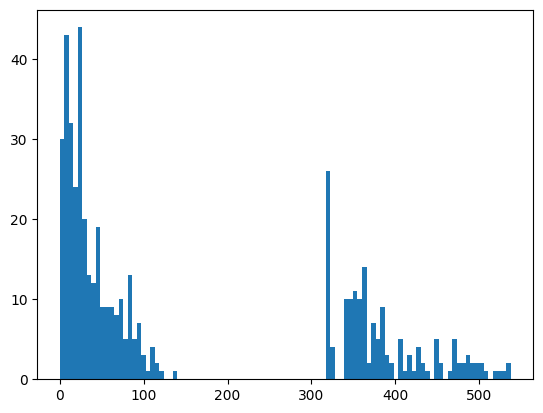

In [189]:
plt.hist(metric_scores, bins=100)
plt.show()

Position 3 choice of tool splits the dataset (PeptideProphet, PTMprophet and iProphet) so lets look at them each separately 

In [ ]:
pos_three_candidates = ['PeptideProphet', 'PTMprophet', 'iProphet']
candidate_scores = []
candidate_tuples = []
for candidate in pos_three_candidates:
    non_candidates = [c for c in pos_three_candidates if c != candidate]
    tpp_tool_dropped_candidate = tpp_tools[tpp_tools['name']!= non_candidates[0]]
    tpp_tool_dropped_candidate = tpp_tool_dropped_candidate[tpp_tool_dropped_candidate['name']!= non_candidates[1]]
    tools_by_positions = {}
    
    for i in range(1, 7):
        tools_by_positions[i] = tpp_tool_dropped_candidate[tpp_tool_dropped_candidate['position'] == i]['id'].tolist()

    all_combinations = tool_permutations(tools_by_positions)
    tuple_workflows = [tuple_workflow_from_list(workflow) for workflow in all_combinations]
    metric_scores = [complete_tree(graph, workflow) for workflow in tuple_workflows]

    candidate_tuples.append(tuple_workflows)
    candidate_scores.append(metric_scores)

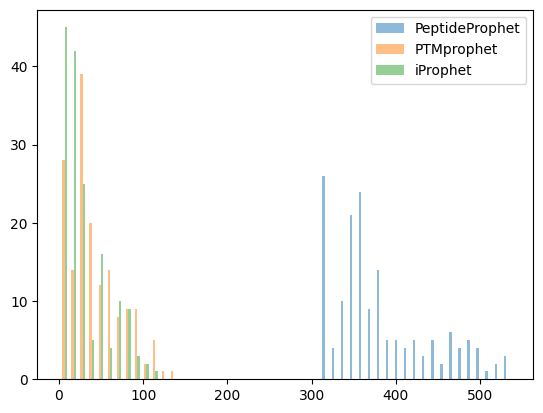

In [211]:

plt.hist(candidate_scores, bins=50, alpha=0.5, label=pos_three_candidates)
plt.legend()
plt.show()


PeptideProphet is cited together with the other tools more often than PTM- and iProphet

In [11]:
with open('../out_202407041439/edgestopic_0121.json', "r") as f: # as generated by create_network
    citation_data_file = json.load(f)

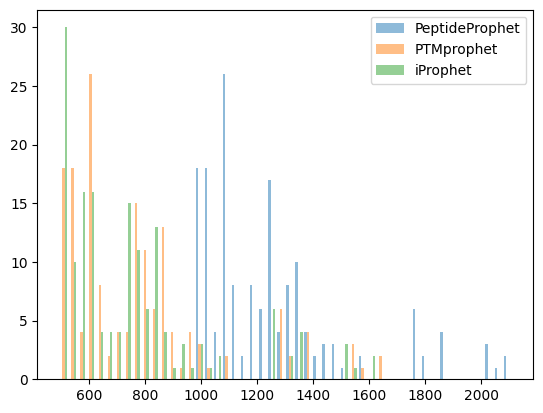

In [27]:
# difference if using median 
pos_three_candidates = ['PeptideProphet', 'PTMprophet', 'iProphet']
candidate_scores = []
candidate_tuples = []

for candidate in pos_three_candidates:
    non_candidates = [c for c in pos_three_candidates if c != candidate]
    tpp_tool_dropped_candidate = tpp_tools[tpp_tools['name']!= non_candidates[0]]
    tpp_tool_dropped_candidate = tpp_tool_dropped_candidate[tpp_tool_dropped_candidate['name']!= non_candidates[1]]
    tools_by_positions = {}
    
    for i in range(1, 7):
        tools_by_positions[i] = tpp_tool_dropped_candidate[tpp_tool_dropped_candidate['position'] == i]['id'].tolist()

    all_combinations = tool_permutations(tools_by_positions)
    tuple_workflows = [tuple_workflow_from_list(workflow) for workflow in all_combinations]
    metric_scores = [median_citations( workflow, citation_data_file) for workflow in tuple_workflows]

    candidate_tuples.append(tuple_workflows)
    candidate_scores.append(metric_scores)

plt.hist(candidate_scores, bins=50, alpha=0.5, label=pos_three_candidates)
plt.legend()
plt.show()


Using the citation metric there is not the same split